In [1]:
from pathlib import Path

def find_project_root(start=None):
    if start is None:
        start = Path.cwd().resolve()
    for p in [start] + list(start.parents):
        if (p / "data").exists():
            return p
    return start


PROJECT_ROOT = find_project_root()
DATA_INTERIM = PROJECT_ROOT / "data" / "interim"
PROJECT_ROOT, DATA_INTERIM

import sys


In [2]:
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


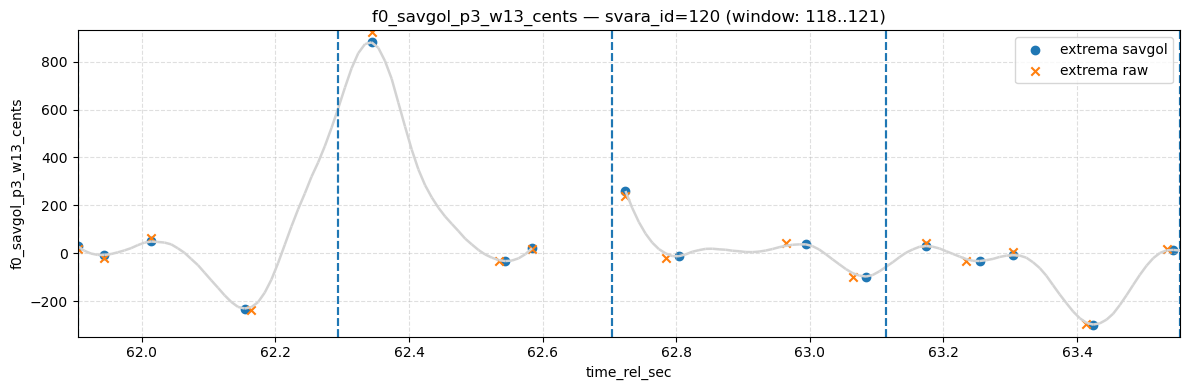

In [6]:
from src.io.pitch_io import load_peaks, load_preprocessed_pitch
from src.utils.plot import plot_svara_window_with_flat_regions, add_peaks_to_ax
from src.io.annotation_io import load_annotations
from src.annotations.svara import attach_svara_annotations_to_pitch
import matplotlib.pyplot as plt
import settings as S

RECORDINGS_ID = S.SARASUDA_VARNAM
recording_id = S.CURRENT_PIECE
TONICS = S.SARASUDA_TONICS
DATA_INTERIM = S.DATA_INTERIM
ann_path = S.DATA_CORPUS / recording_id / "raw" / f"{recording_id}_ann_svara.tsv"


df_pitch = load_preprocessed_pitch(recording_id, root_dir=DATA_INTERIM, tonic_hz=TONICS[recording_id], convert_to_cents=True)

df_svaras = load_annotations(
        file_path=ann_path,
        annotation_type="svara",

    )

df_pitch = attach_svara_annotations_to_pitch(df_pitch=df_pitch, df_svaras=df_svaras)

df_peaks = load_peaks(recording_id, root_dir=DATA_INTERIM)


fig, ax = plot_svara_window_with_flat_regions(
    df_pitch,
    svara_id=120,
    window_n=3,
    pitch_col="f0_savgol_p3_w13_cents",
)

add_peaks_to_ax(ax, df_peaks, show="both", kind="both")
ax.legend()
plt.show()
